<a href="https://colab.research.google.com/github/AryanJadhao/Vision-Transformer/blob/main/VLM_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [78]:
import math, random
import torch
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

## Variables

In [79]:
from torch.cuda import temperature
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_size = 32
embed_size = 64
attention_heads = 4
batch_size = 12
Temperature = 0.07
epochs = 20
Lr = 3e-4

## Synthetic Dataset Properties

In [80]:
colors= ['red','green','blue','yellow','purple','orange','pink','brown','gray']
shapes = ['square','circle','triangle']
positions = ['left','center','right','top','bottom','top-left','top-right','bottom-left','bottom-right']

## Drawing Image Shapes

In [81]:
def draw_sample(color, shapes, positions, img_size=img_size):
  img = Image.new('RGB', (img_size, img_size), 'white')
  draw = ImageDraw.Draw(img)

  margin = 6
  h = w = img_size - 2*margin

  # Calculate x coordinates
  if 'left' in positions:
    x0 = margin
    x1 = margin + w // 2
  elif 'top-left' in positions:
    x0 = margin
    x1 = margin + w // 2
  elif 'bottom-left' in positions:
    x0 = margin
    x1 = margin + w // 2
  elif 'right' in positions:
    x0 = margin + w // 2
    x1 = img_size - margin
  elif 'top-right' in positions:
    x0 = margin + w // 2
    x1 = img_size - margin
  elif 'bottom-right' in positions:
    x0 = margin + w // 2
    x1 = img_size - margin
  else:
    x0 = margin + w // 4
    x1 = margin + 3*w // 4

  # calculate y coordinates
  if 'top' in positions:
    y0 = margin
    y1 = margin + h // 2
  elif 'top-left' in positions:
    y0 = margin
    y1 = margin + h // 2
  elif 'top-right' in positions:
    y0 = margin
    y1 = margin + h // 2
  elif 'bottom' in positions:
    y0 = margin + h // 2
    y1 = img_size - margin
  elif 'bottom-left' in positions:
    y0 = margin + h // 2
    y1 = img_size - margin
  elif 'bottom-right' in positions:
    y0 = margin + h // 2
    y1 = img_size - margin
  else:
    y0 = margin + h // 4
    y1 = margin + 3*h // 4

  if shapes == 'square':
    draw.rectangle([x0,y0,x1,y1], fill=color, outline='black')
  elif shapes == 'circle':
    draw.ellipse([x0,y0,x1,y1], fill=color, outline='black')
  else:
    draw.polygon([(x0+(x1-x0)//2, y0),(x0,y1),(x1,y1)], fill=color, outline='black')

  return img

## class for building our dataset

In [82]:
import numpy as np

In [83]:
class shapesDataset():
  def __init__(self):
    self.images = []
    self.captions = []

    for c in colors:
      for s in shapes:
        for p in positions:
          img = draw_sample(c,s,p)
          cap = f"{c} {s} {p}"

          self.images.append(torch.from_numpy(np.asarray(img)).permute(2,0,1).float()/255.0)
          self.captions.append(cap)

    self.vocab, self.word2idx = self.build_vocab(self.captions)

  def __len__(self):
    return len(self.images)

  def build_vocab(self, texts):
      words = sorted({w for t in texts for w in t.split()})
      vocab = ['[CLS]'] + words
      w2i = {w:i for i,w in enumerate(vocab)}

      return vocab, w2i

  def encode_text(self,text):
      toks = [self.word2idx['[CLS]']] + [self.word2idx[w] for w in text.split()]
      return torch.tensor(toks, dtype=torch.long)

  def __getitem__(self,idx):
      return self.images[idx], self.encode_text(self.captions[idx])

In [84]:
full_ds = shapesDataset()
vocab_size = len(full_ds.vocab)
print(vocab_size)
print(full_ds.vocab)

22
['[CLS]', 'blue', 'bottom', 'bottom-left', 'bottom-right', 'brown', 'center', 'circle', 'gray', 'green', 'left', 'orange', 'pink', 'purple', 'red', 'right', 'square', 'top', 'top-left', 'top-right', 'triangle', 'yellow']


##Train-Val data creation

In [85]:
train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size])


##DataLoader

In [86]:
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle=True)
val_loader =  DataLoader(val_ds, batch_size = batch_size, shuffle=False)

## Display Sample Images

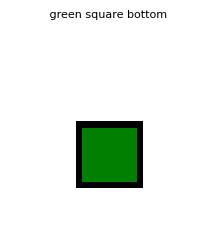

In [87]:
imgs, encoded_caps = next(iter(train_loader))
idx = random.randint(0, len(imgs)-1)
img = (imgs[idx].permute(1,2,0).numpy()*255).astype(np.uint8)  #convert to displayable images

# decode the captions
captions_tokens = encoded_caps[idx].tolist()
caption = " ".join([full_ds.vocab[i] for i in captions_tokens if i in range(len(full_ds.vocab))])
caption = caption.replace("[CLS]","")

plt.figure(figsize=(2.5,2.5))
plt.imshow(img)
plt.title(caption, fontsize=8)
plt.axis('off')
plt.show()

##Image Encoder

In [88]:
class ImageEncoder(nn.Module):
  def __init__(self, embed_dim=embed_size):
    super().__init__()
    self.convolutions = nn.Sequential(
        nn.Conv2d(3,32,3,2,1),
        nn.ReLU(),
        nn.Conv2d(32,64,3,2,1),
        nn.ReLU(),
        nn.Conv2d(64,128,3,2,1),
        nn.ReLU(),
        nn.Conv2d(128,256,3,2,1),
        nn.ReLU(),
    )

    self.projection = nn.Linear(256, embed_dim)
    self.layernorm1 = nn.LayerNorm(embed_dim)

  def forward(self, x):
    x = self.convolutions(x)
    x = x.mean(dim=[2,3])
    x = self.projection(x)
    x = F.normalize(self.layernorm1(x), dim=-1)

    return x

##Text Encoder

In [89]:
class TextEncoder(nn.Module):
  def __init__(self, vocab_size, embed_dim=embed_size, num_heads =attention_heads, context_window=4):
    super().__init__()
    self.token_embedding = nn.Embedding(vocab_size, embed_dim)
    self.position_embedding = nn.Embedding(context_window, embed_dim)
    self.mha = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
    self.projection = nn.Linear(embed_dim, embed_dim)
    self.norm = nn.LayerNorm(embed_dim)

  def forward(self, toks):
    N,L = toks.shape
    position_emb_ids = torch.arange(L, device=toks.device).unsqueeze(0).expand(N,L)
    position_embedding_vectors = self.position_embedding(position_emb_ids)
    token_emb_ids = toks
    token_embedding_vectors = self.token_embedding(token_emb_ids)

    x = token_embedding_vectors + position_embedding_vectors
    x = self.mha(x, x, x)[0]
    x = x[:,0]
    x = self.projection(x)
    x = F.normalize(self.norm(x), dim=-1)
    return x

##CLIP loss

In [90]:
def clip_loss(img_emb, txt_emb, temperature=Temperature):
  logits = (img_emb @ txt_emb.T) / temperature
  targets = torch.arange(img_emb.size(0), device=img_emb.device)
  loss_i = F.cross_entropy(logits, targets)
  loss_t = F.cross_entropy(logits.T, targets)
  return ((loss_i + loss_t)/2.0)

##Model, data, optimizer

In [91]:
img_enc = ImageEncoder().to(device)
txt_enc = TextEncoder(vocab_size).to(device)
params = list(img_enc.parameters()) + list(txt_enc.parameters())
optimizer = torch.optim.AdamW(params, lr=Lr)

In [92]:
# training loop
best_val = float('inf')

for epoch in range(1, epochs+1):
  img_enc.train()
  txt_enc.train()

  total = 0.0

  for imgs, toks in train_loader:
    imgs = imgs.to(device)
    toks = toks.to(device)
    optimizer.zero_grad()
    img_emb = img_enc(imgs)
    txt_emb = txt_enc(toks)
    loss = clip_loss(img_emb, txt_emb)
    loss.backward()
    optimizer.step()
    total += loss.item()*imgs.size(0)
  train_loss = total/(len(train_loader)*batch_size)

  # quick val
  img_enc.eval()
  txt_enc.eval()

  with torch.no_grad():
    vtotal, n = 0.0, 0
    for imgs, toks in val_loader:
      imgs = imgs.to(device)
      toks = toks.to(device)

      vtotal += clip_loss(img_enc(imgs), txt_enc(toks)).item()*imgs.size(0)

      n += imgs.size(0)
    val_loss = vtotal/n

  print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

  if val_loss < best_val:
    best_val = val_loss

Epoch 01 | Train Loss: 2.3598 | Val Loss: 2.4219
Epoch 02 | Train Loss: 2.2948 | Val Loss: 2.1569
Epoch 03 | Train Loss: 1.5853 | Val Loss: 1.4274
Epoch 04 | Train Loss: 1.0213 | Val Loss: 0.9014
Epoch 05 | Train Loss: 0.6972 | Val Loss: 0.5711
Epoch 06 | Train Loss: 0.5707 | Val Loss: 0.4331
Epoch 07 | Train Loss: 0.5020 | Val Loss: 0.5788
Epoch 08 | Train Loss: 0.4210 | Val Loss: 0.3337
Epoch 09 | Train Loss: 0.2961 | Val Loss: 0.2820
Epoch 10 | Train Loss: 0.1873 | Val Loss: 0.2670
Epoch 11 | Train Loss: 0.1769 | Val Loss: 0.1770
Epoch 12 | Train Loss: 0.1554 | Val Loss: 0.1712
Epoch 13 | Train Loss: 0.1295 | Val Loss: 0.1730
Epoch 14 | Train Loss: 0.1048 | Val Loss: 0.1675
Epoch 15 | Train Loss: 0.1371 | Val Loss: 0.2529
Epoch 16 | Train Loss: 0.1330 | Val Loss: 0.2739
Epoch 17 | Train Loss: 0.1419 | Val Loss: 0.1371
Epoch 18 | Train Loss: 0.1020 | Val Loss: 0.1014
Epoch 19 | Train Loss: 0.0723 | Val Loss: 0.0927
Epoch 20 | Train Loss: 0.0555 | Val Loss: 0.1241
